In [3]:
###### IMPORT LIBRARIES AND SET UP PARAMETERS

# Import libraries
import os
import pandas as pd
import numpy as np
import pyflux as pf
from pandas_datareader import DataReader
from datetime import datetime
from matplotlib import pyplot
from scipy.stats import norm

In [4]:
# Set up directory
dir="/media/mourad/diskSave/MCF_Toulouse/recherche/ConsulProj/RamCiri"
os.chdir(dir)
print(os.getcwd())

/media/mourad/diskSave/MCF_Toulouse/recherche/ConsulProj/RamCiri


In [5]:
# Parameters
symbol="GOOG" # Set up the symbol you want
kdays=30 # Number of days for forecasting

In [6]:
# Create folder for symbol
symbolFolder="results/ARIMA/"+symbol
os.mkdir(symbolFolder, mode=0o777)

FileExistsError: [Errno 17] File exists: 'results/ARIMA/GOOG'

In [7]:
###### LOAD AND PREPROCESS DATA

# Import price
path="data/stockquotes/samples_L3_stockquotes_sample.csv.gz"
data_stockquotes = pd.read_csv(path, compression='gzip', header=0, sep=',', quotechar='"', error_bad_lines=False)
data_stockquotes["quotedate"] = pd.to_datetime(data_stockquotes["quotedate"])
print(data_stockquotes)
print(np.unique(data_stockquotes["symbol"]))

      symbol  quotedate        open        high         low       close  \
0         BA 2015-05-26  144.339996  144.429993  142.160004  142.800003   
1         BA 2015-06-18  143.910004  146.529999  143.910004  145.380005   
2         BA 2015-06-26  143.029999  143.039993  141.889999  142.479996   
3         BA 2016-02-09  117.980003  119.980003  117.430000  118.879997   
4         BA 2016-05-27  128.960007  129.699997  128.830002  129.220001   
...      ...        ...         ...         ...         ...         ...   
26833   NFLX 2019-06-13  347.230000  348.500000  339.250000  343.430000   
26834   NFLX 2019-10-04  268.200000  275.484600  266.470000  272.790000   
26835   NFLX 2019-11-13  291.030000  293.410000  281.140000  283.110000   
26836   NFLX 2020-01-03  326.780000  329.859900  325.530000  325.900000   
26837   NFLX 2020-04-23  419.260000  438.413000  419.260000  426.700000   

         volume  adjustedclose  
0       3476800     141.894694  
1       3728900     144.458340  


In [8]:
# Choose the stock
data_stockquotes_sel=data_stockquotes[data_stockquotes["symbol"]==symbol]
data_stockquotes_sel=data_stockquotes_sel.sort_values('quotedate')
data_stockquotes_sel=data_stockquotes_sel.set_index('quotedate')
print(data_stockquotes_sel)

           symbol         open         high          low        close  \
quotedate                                                               
2015-05-01   GOOG   538.429993   539.539978   532.099976   537.900024   
2015-05-04   GOOG   538.530029   544.070007   535.059998   540.780029   
2015-05-05   GOOG   538.210022   539.739990   530.390991   530.799988   
2015-05-06   GOOG   531.239990   532.380005   521.085022   524.219971   
2015-05-07   GOOG   523.989990   533.460022   521.750000   530.700012   
...           ...          ...          ...          ...          ...   
2020-05-22   GOOG  1396.710000  1412.760000  1391.830000  1410.420000   
2020-05-26   GOOG  1437.270000  1441.000000  1412.130000  1417.020000   
2020-05-27   GOOG  1417.250000  1421.740000  1391.290000  1417.840000   
2020-05-28   GOOG  1396.860000  1440.840000  1396.000000  1416.730000   
2020-05-29   GOOG  1416.940000  1432.570000  1413.350000  1428.920000   

             volume  adjustedclose  
quotedate    

In [9]:
# Check the absence of missing data 
NAcount=data_stockquotes.isnull().sum().sum()
print("Missing data=",NAcount)

Missing data= 0


In [10]:
# Extract close price
priceClose=data_stockquotes_sel["close"]
print(priceClose)

quotedate
2015-05-01     537.900024
2015-05-04     540.780029
2015-05-05     530.799988
2015-05-06     524.219971
2015-05-07     530.700012
                 ...     
2020-05-22    1410.420000
2020-05-26    1417.020000
2020-05-27    1417.840000
2020-05-28    1416.730000
2020-05-29    1428.920000
Name: close, Length: 1278, dtype: float64


Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1267, 1268, 1269, 1270, 1271, 1272, 1273, 1274, 1275, 1276],
           dtype='int64', length=1277)
             0
0     0.005340
1    -0.018627
2    -0.012474
3     0.012286
4     0.014070
...        ...
1272  0.005417
1273  0.004669
1274  0.000579
1275 -0.000783
1276  0.008568

[1277 rows x 1 columns]


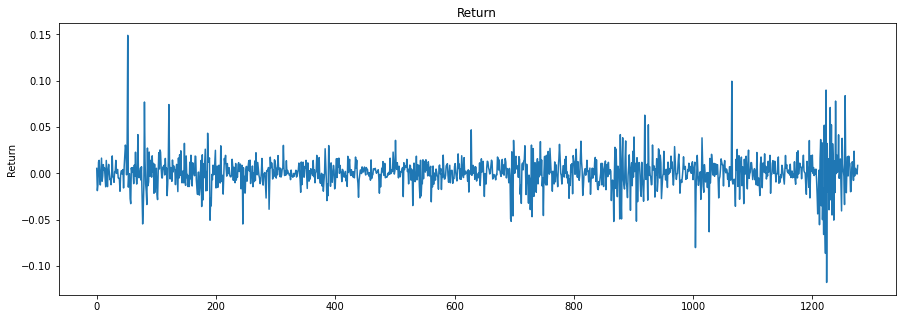

In [29]:
# Plot volatility variability over time
# If volatility varies over time, then the GARCH model is more appropriate than ARIMA model
# For instance, for GOOG, volatility is high in 2015 and 2020 compared to other years.
# Volatility is important for you since high volatility means a broad probability graph!
returnClose.index = returnClose.index.values
print(returnClose.index)
returnClose = pd.DataFrame(np.diff(np.log(priceClose.values)),index=returnClose.index)
print(returnClose)

pyplot.figure(figsize=(15,5));
pyplot.plot(returnClose.index,returnClose);
pyplot.ylabel('Return');
pyplot.title('Return');

In [25]:
###### BUILD AND AUTOSELECT GARCH MODEL

# Split train/test data
# Note to Rim and Quinn: train data will be used only to build the model, 
# and test data will be used only to assess forecasting accuracy of the model.
returnCloseTrain = returnClose[0:(len(returnClose)-kdays)]
returnCloseTest = returnClose[(len(returnClose)-kdays):len(returnClose)]
print(returnCloseTrain)
print(returnCloseTest[0:5])

             0
0     0.005340
1    -0.018627
2    -0.012474
3     0.012286
4     0.014070
...        ...
1242  0.000966
1243  0.005031
1244  0.041562
1245 -0.005340
1246  0.000792

[1247 rows x 1 columns]
             0
1247  0.015534
1248 -0.013052
1249 -0.040498
1250  0.037810
1251  0.010317


In [26]:
# Build GARCH model and finding automatically the best GARCH model 
# Note to Rim and Quinn: ....
# https://pyflux.readthedocs.io/en/latest/garch.html
GARCHmodel = pf.GARCH(returnCloseTrain,p=1,q=1)
x = model.fit()
x.summary()

AttributeError: 'DataFrame' object has no attribute 'ix'

In [27]:
# Results from auto_arima
# Note to Rim and Quinn: The ARIMA model with the lowest AIC (Akaike Information Criterion) is selected.
# Basically, AIC seeks for the best model fit, while also looking for model parcimony, 
# (less complex model = higher parcimony). 
# There are other criteria that can be used such as BIC and HQIC. AIC is preferred here.
# order=(X, X, X) is the ARIMA model selected.
print(autoARIMA)

NameError: name 'autoARIMA' is not defined

In [ ]:
# Details of the selected ARIMA model
# Note to Rim and Quinn: You can find the AIC value of the selected model. 
# Important information from the summary: the coef table.
# In the coef table, you see the parameter coef of the model and the associated p-value.
# ar.L1 is the autoregressive parameter of lag=1. If present.
# ma.L1 is the moving average parameter of lag=1. If present.
print(autoARIMA.summary())

In [ ]:
###### CHECK MODEL ASSUMPTIONS

# Plot residual errors
# Note to Rim and Quinn: For the ARIMA model to be valid, 
# the residual errors should be near zero mean and present uniform variance. 
plotResiduals=symbolFolder+"/plot_ARIMA_residuals_"+symbol+".pdf"
residuals=pd.DataFrame(autoARIMA.resid())
fig, ax = pyplot.subplots(2,constrained_layout=True)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
pyplot.savefig(plotResiduals, bbox_inches='tight')
pyplot.show()

In [ ]:
###### FORECAST PRICE USING ARIMA MODEL

# Forecast with confidence interval (alpha=5%)
future_forecast, conf_int = autoARIMA.predict(n_periods=kdays,return_conf_int=True,alpha=0.05)
future_forecast = pd.DataFrame(future_forecast,columns=['future_forecast'],index=priceCloseTest.index.values)
priceCloseTest = pd.DataFrame(priceCloseTest)

In [ ]:
# Simple forecast plot
plotForeCastSimple=symbolFolder+"/plot_ARIMA_forecast_simple_"+symbol+".pdf"
pyplot.plot(priceCloseTest, 'r', label='Actual Price') # plotting t, a separately 
pyplot.plot(future_forecast, 'g', label='Predicted Price') # plotting t, b separately 
pyplot.legend(loc='upper right')
pyplot.xlabel('Date', fontsize=18)
pyplot.ylabel('Stock price', fontsize=18)
pyplot.savefig(plotForeCastSimple, bbox_inches='tight')
pyplot.show()

In [ ]:
# Better forecast plots
plotForeCastBetter=symbolFolder+"/plot_ARIMA_forecast_better_"+symbol+".pdf"
fig, axes = pyplot.subplots(2, 1, figsize=(12, 12))

# --------------------- Actual vs. Predicted --------------------------
axes[0].plot(priceCloseTrain, color='blue', label='Training Data')
axes[0].plot(priceCloseTest.index, future_forecast, color='green', linewidth=4, label='Predicted Price')

axes[0].plot(priceCloseTest.index, priceCloseTest, color='red', label='Actual Price')
axes[0].set_title('Prices Prediction')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Prices')
axes[0].legend()


# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(priceCloseTrain, color='blue', label='Training Data')
axes[1].plot(priceCloseTest.index, future_forecast, color='green',
             label='Predicted Price')

axes[1].set_title('Prices Predictions & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Prices')

conf_int = np.asarray(conf_int)
axes[1].fill_between(priceCloseTest.index, conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange', label="95% Confidence Intervals")
axes[1].legend()
pyplot.savefig(plotForeCastBetter, bbox_inches='tight')

In [ ]:
###### PROBABILITY GRAPH FROM ARIMA MODEL

# Note to Rim and Quinn: ARIMA model computes a predicted mean mu at kdays and a 95% confidence interval
# To compute the probability graph (AKA density function in statistics),
# we calculate the Standard Error (SE) from the lower bound of the confidence interval.
# Once we have the mean mu and the SE, then we can plot the probability graph.

# Current price
priceCloseCurrent=priceCloseTrain.iloc[len(priceCloseTrain)-1]

# Extract predicted mean and confidence interval
mu=future_forecast.iloc[kdays-1,0]
lower=conf_int[kdays-1,0]
print("mu="+str(round(mu,3)))

# Compute Standard Error (SE) from predicted confidence interval (reverse engineering here ;) )
se=(mu-lower)/norm.ppf(0.975)
print("SE="+str(round(se,3)))

# Probability graph
plotProbabilityGraph=symbolFolder+"/plot_ARIMA_probabilityGraph_"+symbol+"_"+str(kdays)+"days.pdf"
x = np.linspace(mu - 3*se, mu + 3*se, 100)
pyplot.plot(x, norm.pdf(x, mu, se))
pyplot.axvline(x=priceCloseCurrent,color='red',label='Current Price')
pyplot.xlabel('Stock price ($)', fontsize=18)
pyplot.ylabel('Probability', fontsize=18)
pyplot.legend(loc='upper right')
pyplot.savefig(plotProbabilityGraph, bbox_inches='tight')
pyplot.show()